Found 101 files.


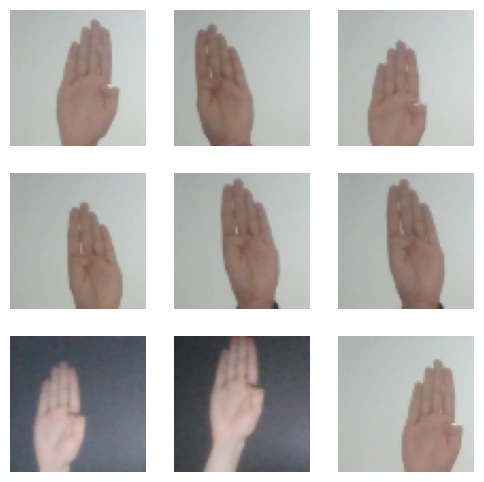

In [5]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

# Define dataset parameters
IMG_SIZE = 64  # Standard for DCGAN
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Function to load and preprocess dataset
def load_dataset(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        label_mode=None,  # No labels required
        image_size=(IMG_SIZE, IMG_SIZE),  # Resize images correctly
        batch_size=None  # Do not batch here!
    )

    # Resize and normalize images manually
    dataset = dataset.map(lambda x: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)) / 127.5) - 1.0)

    # Batch after resizing
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    return dataset

# Load dataset
dataset_path = "/content/B-samples"  # Update path if needed
dataset = load_dataset(dataset_path)

# Visualize some images
plt.figure(figsize=(6,6))
for images in dataset.take(1):
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow((images[i].numpy() + 1) / 2)  # Convert back to [0,1] range
        plt.axis('off')
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

# Define Generator Model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),  # Fully connected layer
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),  # Reshape to 8x8x256

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])

    return model

# Create generator
generator = build_generator()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [7]:
# Define Discriminator Model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    return model

# Create discriminator
discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Define GAN Model
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')

    discriminator.trainable = False  # Freeze discriminator when training GAN
    gan_input = tf.keras.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')

    return gan

# Create GAN
gan = build_gan(generator, discriminator)
gan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 64, 64, 3)           │       2,733,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         242,561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,976,065 (11.35 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 275,713 (1.05 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss = 0.7098, G Loss = 0.6296


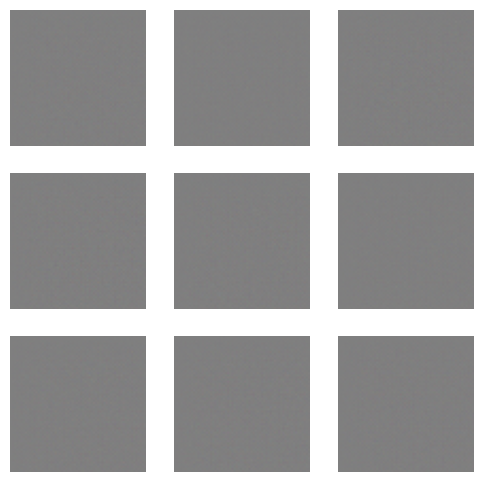

KeyboardInterrupt: 

In [9]:
import numpy as np
import time
from IPython.display import display, clear_output

EPOCHS = 500  # Adjust based on need
BATCH_SIZE = 64
NOISE_DIM = 100

# Training function
def train_gan(dataset, epochs):
    for epoch in range(epochs):
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Generate fake images
            noise = tf.random.normal([batch_size, NOISE_DIM])
            fake_images = generator(noise, training=True)

            # Create labels for real (1) and fake (0)
            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train generator (via GAN model)
            noise = tf.random.normal([batch_size, NOISE_DIM])
            g_loss = gan.train_on_batch(noise, tf.ones((batch_size, 1)))  # Wants to fool discriminator

        # Display progress
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss:.4f}, G Loss = {g_loss:.4f}")
            generate_and_save_images(generator, epoch, NOISE_DIM)

# Function to visualize generated images
def generate_and_save_images(model, epoch, noise_dim):
    noise = tf.random.normal([9, noise_dim])
    generated_images = model(noise, training=False)

    generated_images = (generated_images + 1) / 2  # Convert back to [0,1] range

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')

    plt.show()

# Train the GAN
train_gan(dataset, EPOCHS)


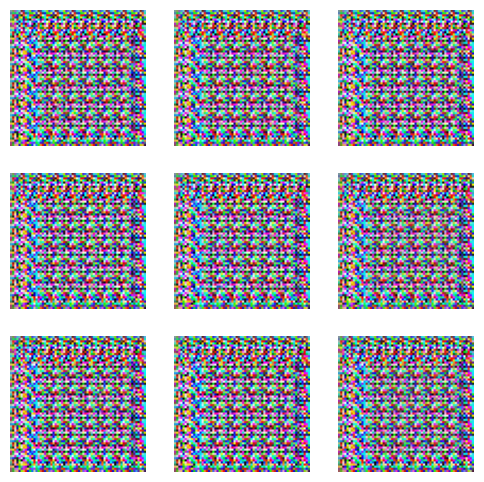

In [10]:
# Generate new images after training
noise = tf.random.normal([9, 100])
generated_images = generator(noise, training=False)

# Display generated images
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow((generated_images[i].numpy() + 1) / 2)
    plt.axis('off')
plt.show()



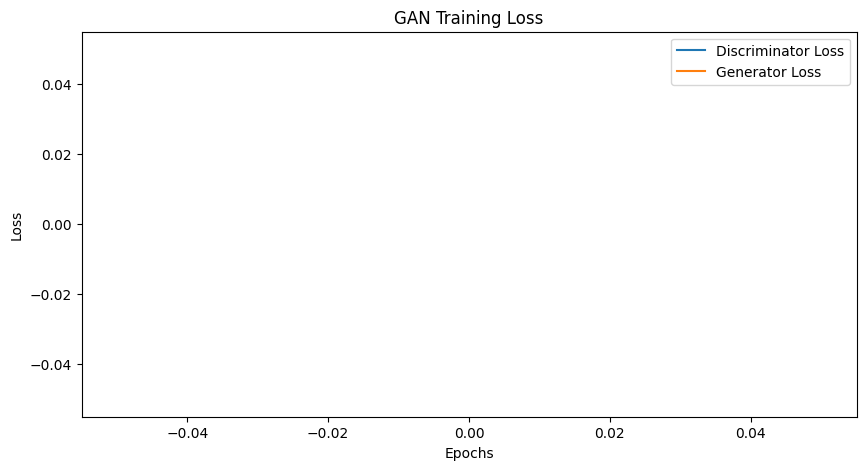

In [15]:
import matplotlib.pyplot as plt

def plot_loss(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("GAN Training Loss")
    plt.show()

# Assuming we stored losses in lists:
plot_loss(d_losses, g_losses)


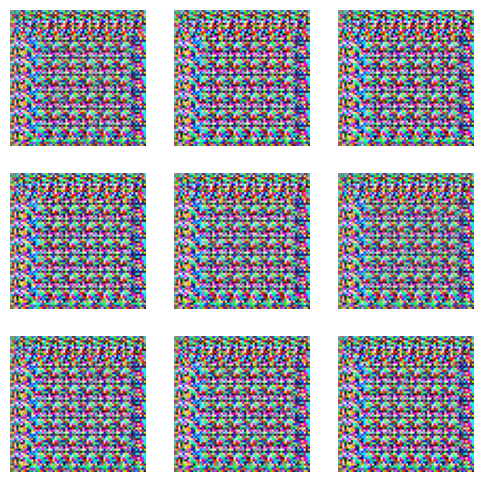

In [16]:
# Generate and display images
def generate_images(model, num_images=9):
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise, training=False)

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = (generated_images[i].numpy() + 1) / 2  # Convert from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis('off')

    plt.show()

generate_images(generator)


In [17]:
generator.save("dcgan_generator.h5")
print("Generator Model Saved!")


Generator Model Saved!


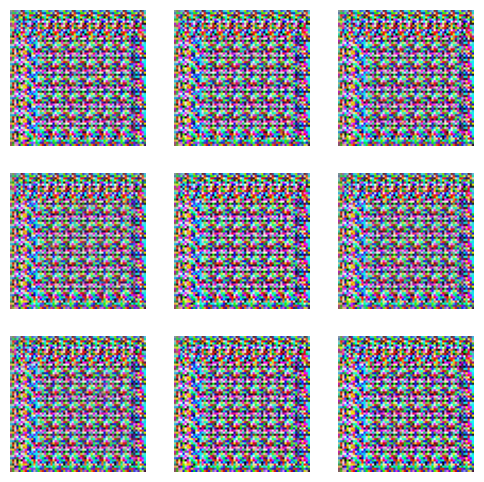

In [18]:
from tensorflow.keras.models import load_model

# Load trained generator
saved_generator = load_model("dcgan_generator.h5")

# Generate images with the saved model
generate_images(saved_generator)


In [24]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy
import numpy as np

# Load InceptionV3 with classification head
inception_model = InceptionV3(include_top=True, weights="imagenet")

def calculate_inception_score(images, n_splits=10):
    # Resize images to InceptionV3 input size
    images_resized = tf.image.resize(images, (299, 299))

    # Preprocess for InceptionV3
    images_resized = preprocess_input(images_resized)

    # Get predictions (Softmax probabilities of shape (batch_size, 1000))
    preds = inception_model.predict(images_resized, batch_size=32)

    # Ensure valid probability distribution
    preds = np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True)

    scores = []
    for i in np.array_split(preds, n_splits):
        p_yx = i  # Already a probability distribution
        p_y = np.mean(p_yx, axis=0, keepdims=True)  # Keep dims to match

        # Compute KL divergence safely
        kl_div = entropy(p_yx.T, p_y.T, axis=0)
        scores.append(np.exp(np.mean(kl_div)))  # Compute mean score

    return np.mean(scores), np.std(scores)

# Generate images
num_images = 100
noise = tf.random.normal([num_images, 100])
generated_images = generator(noise, training=False)

# Normalize images to [0,1] range
generated_images = (generated_images + 1) / 2

# Compute IS
is_mean, is_std = calculate_inception_score(generated_images)
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step
Inception Score: 1.0000 ± 0.0000


In [29]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Load InceptionV3 model without the classification head (feature extraction)
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def ensure_rgb(images):
    """Ensure images have 3 channels (RGB)"""
    if images.shape[-1] == 1:  # Grayscale images
        images = tf.image.grayscale_to_rgb(images)
    return images

def calculate_fid(real_images, fake_images):
    # Ensure RGB format
    real_images = ensure_rgb(real_images)
    fake_images = ensure_rgb(fake_images)

    # Resize images to match InceptionV3 input shape
    real_images = tf.image.resize(real_images, (299, 299))
    fake_images = tf.image.resize(fake_images, (299, 299))

    # Preprocess images
    real_images = preprocess_input(real_images)
    fake_images = preprocess_input(fake_images)

    # Ensure batch dimension
    if real_images.shape.ndims == 3:
        real_images = tf.expand_dims(real_images, axis=0)
    if fake_images.shape.ndims == 3:
        fake_images = tf.expand_dims(fake_images, axis=0)

    # Extract features using InceptionV3
    real_features = inception_model.predict(real_images, batch_size=32)
    fake_features = inception_model.predict(fake_images, batch_size=32)

    # Compute mean
    mu_real = real_features.mean(axis=0)
    mu_fake = fake_features.mean(axis=0)

    # Compute covariance and ensure it’s a matrix
    if real_features.shape[0] > 1:
        sigma_real = np.cov(real_features, rowvar=False)
    else:
        sigma_real = np.zeros((real_features.shape[1], real_features.shape[1]))

    if fake_features.shape[0] > 1:
        sigma_fake = np.cov(fake_features, rowvar=False)
    else:
        sigma_fake = np.zeros((fake_features.shape[1], fake_features.shape[1]))

    # Compute Fréchet Distance
    ssdiff = np.sum((mu_real - mu_fake) ** 2)
    covmean = sqrtm(sigma_real @ sigma_fake)

    # Handle numerical instabilities
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Load real images from dataset
real_images = next(iter(dataset.take(1)))[0]

# Ensure real_images is a NumPy array
if isinstance(real_images, tf.Tensor):
    real_images = real_images.numpy()

# Normalize generated images to match dataset range
generated_images = (generated_images + 1) / 2  # Assuming images are in [-1,1] range

# Compute FID Score
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step
FID Score: 1.2201


In [42]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
from skimage.transform import resize

def preprocess_images(images, target_shape):
    """
    Preprocess images to ensure they have the same shape and number of channels.
    """
    processed_images = []
    for img in images:
        # Resize the image to the target shape
        img_resized = resize(img, target_shape, anti_aliasing=True)

        # Ensure the image has 3 channels (RGB)
        if img_resized.ndim == 2:  # Grayscale image
            img_resized = np.stack([img_resized] * 3, axis=-1)  # Convert to RGB
        elif img_resized.shape[-1] > 3:  # Drop extra channels (e.g., RGBA)
            img_resized = img_resized[:, :, :3]

        processed_images.append(img_resized)

    return np.array(processed_images)

def calculate_ssim(real_images, fake_images):
    """
    Calculate the mean SSIM score between two sets of images.
    Ensures that images are preprocessed correctly before computing SSIM.
    """
    # Ensure both sets of images are NumPy arrays
    real_images = np.array(real_images)
    fake_images = np.array(fake_images)

    # Determine the target shape (height, width) based on real_images
    target_shape = real_images.shape[1:3]  # Height, Width

    # Preprocess both sets of images
    real_images = preprocess_images(real_images, target_shape)
    fake_images = preprocess_images(fake_images, target_shape)

    # Ensure batch sizes match
    min_length = min(len(real_images), len(fake_images))
    real_images, fake_images = real_images[:min_length], fake_images[:min_length]

    # Compute SSIM scores
    scores = []
    for i in range(min_length):
        # Ensure images meet the minimum size requirement (7x7)
        if real_images[i].shape[0] < 7 or real_images[i].shape[1] < 7:
            print(f"Skipping image {i} due to insufficient size: {real_images[i].shape}")
            continue

        # Compute SSIM for each pair of images
        data_range = real_images[i].max() - real_images[i].min()
        score = ssim(
            real_images[i],
            fake_images[i],
            data_range=data_range,
            multichannel=True,  # Enable multichannel for RGB images
            channel_axis=-1,    # Specify the channel axis
            win_size=7          # Use a default window size of 7
        )
        scores.append(score)

    # Return the mean SSIM score
    return np.mean(scores) if scores else 0.0

# Example usage
# Assuming `real_images` and `generated_images` are loaded as NumPy arrays
ssim_score = calculate_ssim(real_images, generated_images)
print(f"SSIM Score: {ssim_score:.4f}")

Skipping image 0 due to insufficient size: (64, 3, 3)
Skipping image 1 due to insufficient size: (64, 3, 3)
Skipping image 2 due to insufficient size: (64, 3, 3)
Skipping image 3 due to insufficient size: (64, 3, 3)
Skipping image 4 due to insufficient size: (64, 3, 3)
Skipping image 5 due to insufficient size: (64, 3, 3)
Skipping image 6 due to insufficient size: (64, 3, 3)
Skipping image 7 due to insufficient size: (64, 3, 3)
Skipping image 8 due to insufficient size: (64, 3, 3)
Skipping image 9 due to insufficient size: (64, 3, 3)
Skipping image 10 due to insufficient size: (64, 3, 3)
Skipping image 11 due to insufficient size: (64, 3, 3)
Skipping image 12 due to insufficient size: (64, 3, 3)
Skipping image 13 due to insufficient size: (64, 3, 3)
Skipping image 14 due to insufficient size: (64, 3, 3)
Skipping image 15 due to insufficient size: (64, 3, 3)
Skipping image 16 due to insufficient size: (64, 3, 3)
Skipping image 17 due to insufficient size: (64, 3, 3)
Skipping image 18 du